In [45]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Deep Q-Networks in Pytorch

In [46]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import random

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

#### Environments

In this notebook, we will implement DQN and run it on four environments which have a consinuous state-space and discrete action-space.  There are:

 * CartPole:  Balance a pole on a moving cart (https://gym.openai.com/envs/CartPole-v1/).
 * Mountain Car:  Gather momentum to climb a hill (https://gym.openai.com/envs/MountainCar-v0/).
 * AcroBot:  A two-link robot needs to swing and reach the area above a line (https://gym.openai.com/envs/Acrobot-v1/).
 * LunarLander:  A spaceship needs to fly and land in the landing spot.  (https://gym.openai.com/envs/LunarLander-v2/).

In [47]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'frozenlake': gym.make('FrozenLake-v0'),
    'frozenlake8': gym.make('FrozenLake8x8-v0'),
    'bipedal': gym.make('BipedalWalker-v2'),
    'bipedalhardcore': gym.make('BipedalWalkerHardcore-v2'),
}

In [50]:
def rolling_average(data, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
#     assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Bipedal Walker PPO implementation

In [53]:
from torch.distributions import MultivariateNormal
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [55]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.Tanh(),
                nn.Linear(32, action_dim),
                nn.Tanh()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.Tanh(),
                nn.Linear(32, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device)
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)
        
        return action.detach()
    
    def evaluate(self, state, action):   
        action_mean = torch.squeeze(self.actor(state))
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(torch.squeeze(action))
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [56]:
class PPO:
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        
        self.policy_old = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()
    
    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).to(device)).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device)).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

## Run PPO

In [63]:
def train_env(env_name, model=None, solved_reward=300, max_episodes=10000, render_reward=100, no_render=True):
    render = False
#     solved_reward = 300         # stop training if avg_reward > solved_reward
    log_interval = 20           # print avg reward in the interval
#     max_episodes = 10000        # max training episodes
    max_timesteps = 1500        # max timesteps in one episode

    update_timestep = 3000      # update policy every n timesteps
    action_std = 0.5            # constant std for action distribution (Multivariate Normal)
    K_epochs = 80               # update policy for K epochs
    eps_clip = 0.1              # clip parameter for PPO
    gamma = 0.99                # discount factor

    lr = 0.0001                 # parameters for Adam optimizer
    betas = (0.9, 0.999)

    random_seed = None
    rewards = []
    lengths = []
    returns = []
    #############################################

    # creating environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    if random_seed:
        print("Random Seed: {}".format(random_seed))
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)

    memory = Memory()
    ppo = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)
    if model:
        ppo.policy.load_state_dict(model)
        ppo.policy_old.load_state_dict(model)
    
    print(lr,betas)

    # logging variables
    running_reward = 0
    avg_length = 0
    time_step = 0

    # training loop
    for i_episode in range(1, max_episodes+1):
        state = env.reset()
        rrs = []
        for t in range(max_timesteps):
            time_step +=1
            # Running policy_old:
            action = ppo.select_action(state, memory)
            state, reward, done, _ = env.step(action)

            # Saving reward and is_terminals:
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            # update if its time
            if time_step % update_timestep == 0:
                ppo.update(memory)
                memory.clear_memory()
                time_step = 0
            running_reward += reward
            rrs.append(reward)
            
            if render:
                env.render()
            if done:
                break

        rewards.append(running_reward)
        lengths.append(t)
        G = 0
        for r in rrs[::-1]:
            G = gamma*G + r
        returns.append(G)
        rrs = []
        
        solved_episode = 0
        if running_reward > solved_reward and solved_episode == 0:
            solved_episode = i_episode
        
        if not no_render and running_reward > render_reward and i_episode > 600:
            render = True
        else:
            render = False

        avg_length += t

        # stop training if avg_reward > solved_reward
        if running_reward > (log_interval*solved_reward):
            print("########## Solved! ##########")
            if model:
                torch.save(ppo.policy.state_dict(), './PPO_continuous_solved_{}_transfer.pth'.format(env_name))
            else:
                torch.save(ppo.policy.state_dict(), './PPO_continuous_solved_{}.pth'.format(env_name))
            break

        # save every 500 episodes
        if i_episode % 500 == 0:
            if model:
                torch.save(ppo.policy.state_dict(), './PPO_continuous_{}_transfer.pth'.format(env_name))
            else:
                torch.save(ppo.policy.state_dict(), './PPO_continuous_{}.pth'.format(env_name))

        # logging
        if i_episode % log_interval == 0:
            avg_length = int(avg_length/log_interval)
            avg_returns = int(sum(returns[i_episode-20:i_episode])/log_interval)
            running_reward = int((running_reward/log_interval))

            print('Episode {} \t Avg length: {} \t Avg reward: {} \t Avg Returns: {}'.format(i_episode, avg_length, running_reward, avg_returns))
            running_reward = 0
            avg_length = 0
    
    env.close()
    return rewards, lengths, returns, solved_episode

### train basic model from scratch

In [64]:
rewards_basic, lengths_basic, returns_basic, solved_episode_basic = train_env('BipedalWalker-v2', solved_reward=300)

0.0001 (0.9, 0.999)
Episode 20 	 Avg length: 1141 	 Avg reward: -67 	 Avg Returns: -17
Episode 40 	 Avg length: 1289 	 Avg reward: -62 	 Avg Returns: -10
Episode 60 	 Avg length: 1217 	 Avg reward: -64 	 Avg Returns: -12
Episode 80 	 Avg length: 1152 	 Avg reward: -65 	 Avg Returns: -12
Episode 100 	 Avg length: 1289 	 Avg reward: -55 	 Avg Returns: -6
Episode 120 	 Avg length: 1356 	 Avg reward: -52 	 Avg Returns: -6
Episode 140 	 Avg length: 1249 	 Avg reward: -60 	 Avg Returns: -7
Episode 160 	 Avg length: 1188 	 Avg reward: -63 	 Avg Returns: -12
Episode 180 	 Avg length: 1361 	 Avg reward: -47 	 Avg Returns: -6
Episode 200 	 Avg length: 1422 	 Avg reward: -44 	 Avg Returns: -5
Episode 220 	 Avg length: 1444 	 Avg reward: -26 	 Avg Returns: -1
Episode 240 	 Avg length: 1394 	 Avg reward: -17 	 Avg Returns: -4
Episode 260 	 Avg length: 1384 	 Avg reward: -4 	 Avg Returns: -2
Episode 280 	 Avg length: 1435 	 Avg reward: 10 	 Avg Returns: 0
Episode 300 	 Avg length: 1499 	 Avg reward:

Episode 2480 	 Avg length: 1457 	 Avg reward: 223 	 Avg Returns: 8
Episode 2500 	 Avg length: 1386 	 Avg reward: 202 	 Avg Returns: 8
Episode 2520 	 Avg length: 1412 	 Avg reward: 213 	 Avg Returns: 4
Episode 2540 	 Avg length: 1267 	 Avg reward: 166 	 Avg Returns: 6
Episode 2560 	 Avg length: 1422 	 Avg reward: 215 	 Avg Returns: 9
Episode 2580 	 Avg length: 1366 	 Avg reward: 198 	 Avg Returns: 9
Episode 2600 	 Avg length: 1439 	 Avg reward: 208 	 Avg Returns: 8
Episode 2620 	 Avg length: 1209 	 Avg reward: 162 	 Avg Returns: 6
Episode 2640 	 Avg length: 1286 	 Avg reward: 171 	 Avg Returns: 8
Episode 2660 	 Avg length: 1167 	 Avg reward: 142 	 Avg Returns: 4
Episode 2680 	 Avg length: 1104 	 Avg reward: 133 	 Avg Returns: 8
Episode 2700 	 Avg length: 1151 	 Avg reward: 141 	 Avg Returns: 7
Episode 2720 	 Avg length: 1065 	 Avg reward: 113 	 Avg Returns: 2
Episode 2740 	 Avg length: 1226 	 Avg reward: 164 	 Avg Returns: 6
Episode 2760 	 Avg length: 1336 	 Avg reward: 192 	 Avg Return

Episode 4940 	 Avg length: 1419 	 Avg reward: 228 	 Avg Returns: 10
Episode 4960 	 Avg length: 1370 	 Avg reward: 207 	 Avg Returns: 9
Episode 4980 	 Avg length: 1226 	 Avg reward: 173 	 Avg Returns: 9
Episode 5000 	 Avg length: 1315 	 Avg reward: 203 	 Avg Returns: 10
Episode 5020 	 Avg length: 1335 	 Avg reward: 207 	 Avg Returns: 9
Episode 5040 	 Avg length: 1400 	 Avg reward: 225 	 Avg Returns: 10
Episode 5060 	 Avg length: 1458 	 Avg reward: 238 	 Avg Returns: 9
Episode 5080 	 Avg length: 1428 	 Avg reward: 217 	 Avg Returns: 9
Episode 5100 	 Avg length: 1456 	 Avg reward: 243 	 Avg Returns: 10
Episode 5120 	 Avg length: 1341 	 Avg reward: 216 	 Avg Returns: 9
Episode 5140 	 Avg length: 1338 	 Avg reward: 210 	 Avg Returns: 9
Episode 5160 	 Avg length: 1414 	 Avg reward: 230 	 Avg Returns: 9
Episode 5180 	 Avg length: 1336 	 Avg reward: 218 	 Avg Returns: 6
Episode 5200 	 Avg length: 1281 	 Avg reward: 203 	 Avg Returns: 9
Episode 5220 	 Avg length: 1347 	 Avg reward: 208 	 Avg Re

Episode 7400 	 Avg length: 1267 	 Avg reward: 202 	 Avg Returns: 6
Episode 7420 	 Avg length: 1386 	 Avg reward: 219 	 Avg Returns: 9
Episode 7440 	 Avg length: 1381 	 Avg reward: 237 	 Avg Returns: 8
Episode 7460 	 Avg length: 1410 	 Avg reward: 231 	 Avg Returns: 10
Episode 7480 	 Avg length: 1130 	 Avg reward: 161 	 Avg Returns: 8
Episode 7500 	 Avg length: 1403 	 Avg reward: 227 	 Avg Returns: 10
Episode 7520 	 Avg length: 1159 	 Avg reward: 160 	 Avg Returns: 5
Episode 7540 	 Avg length: 1294 	 Avg reward: 198 	 Avg Returns: 8
Episode 7560 	 Avg length: 1290 	 Avg reward: 199 	 Avg Returns: 9
Episode 7580 	 Avg length: 1325 	 Avg reward: 214 	 Avg Returns: 8
Episode 7600 	 Avg length: 1209 	 Avg reward: 179 	 Avg Returns: 9
Episode 7620 	 Avg length: 1244 	 Avg reward: 206 	 Avg Returns: 9
Episode 7640 	 Avg length: 1041 	 Avg reward: 132 	 Avg Returns: 9
Episode 7660 	 Avg length: 1270 	 Avg reward: 202 	 Avg Returns: 10
Episode 7680 	 Avg length: 1207 	 Avg reward: 188 	 Avg Ret

KeyboardInterrupt: 

### train slightly different environment from scratch

In [39]:
rewards_scatch, lengths_scratch, returns_scratch, solved_episode_scratch = train_env(
    'BipedalWalkerHardcore-v2',
    solved_reward=20,
    max_episodes=6000,
    render_reward = -60,
#     no_render=False
)

0.0003 (0.9, 0.999)
Episode 20 	 Avg length: 531 	 Avg reward: -93	 Avg Returns -92
Episode 40 	 Avg length: 713 	 Avg reward: -82	 Avg Returns -81
Episode 60 	 Avg length: 913 	 Avg reward: -84	 Avg Returns -83
Episode 80 	 Avg length: 1115 	 Avg reward: -77	 Avg Returns -76
Episode 100 	 Avg length: 1320 	 Avg reward: -68	 Avg Returns -67
Episode 120 	 Avg length: 1355 	 Avg reward: -79	 Avg Returns -78
Episode 140 	 Avg length: 1348 	 Avg reward: -82	 Avg Returns -81
Episode 160 	 Avg length: 1325 	 Avg reward: -74	 Avg Returns -73
Episode 180 	 Avg length: 1286 	 Avg reward: -96	 Avg Returns -95
Episode 200 	 Avg length: 1367 	 Avg reward: -85	 Avg Returns -84
Episode 220 	 Avg length: 1332 	 Avg reward: -78	 Avg Returns -77
Episode 240 	 Avg length: 1445 	 Avg reward: -67	 Avg Returns -67
Episode 260 	 Avg length: 1463 	 Avg reward: -69	 Avg Returns -68
Episode 280 	 Avg length: 1411 	 Avg reward: -76	 Avg Returns -75
Episode 300 	 Avg length: 1221 	 Avg reward: -95	 Avg Returns -

Episode 2480 	 Avg length: 1237 	 Avg reward: -79	 Avg Returns -78
Episode 2500 	 Avg length: 1167 	 Avg reward: -79	 Avg Returns -79
Episode 2520 	 Avg length: 1228 	 Avg reward: -96	 Avg Returns -95
Episode 2540 	 Avg length: 1013 	 Avg reward: -98	 Avg Returns -97
Episode 2560 	 Avg length: 1144 	 Avg reward: -82	 Avg Returns -82
Episode 2580 	 Avg length: 1168 	 Avg reward: -83	 Avg Returns -82
Episode 2600 	 Avg length: 792 	 Avg reward: -102	 Avg Returns -101
Episode 2620 	 Avg length: 962 	 Avg reward: -97	 Avg Returns -96
Episode 2640 	 Avg length: 1382 	 Avg reward: -73	 Avg Returns -73
Episode 2660 	 Avg length: 1159 	 Avg reward: -84	 Avg Returns -83
Episode 2680 	 Avg length: 1241 	 Avg reward: -79	 Avg Returns -78
Episode 2700 	 Avg length: 1222 	 Avg reward: -70	 Avg Returns -69
Episode 2720 	 Avg length: 1220 	 Avg reward: -75	 Avg Returns -74
Episode 2740 	 Avg length: 1039 	 Avg reward: -91	 Avg Returns -90
Episode 2760 	 Avg length: 1244 	 Avg reward: -90	 Avg Returns

Episode 4940 	 Avg length: 1311 	 Avg reward: -102	 Avg Returns -101
Episode 4960 	 Avg length: 1307 	 Avg reward: -81	 Avg Returns -80
Episode 4980 	 Avg length: 1232 	 Avg reward: -90	 Avg Returns -89
Episode 5000 	 Avg length: 1450 	 Avg reward: -71	 Avg Returns -70
Episode 5020 	 Avg length: 1350 	 Avg reward: -88	 Avg Returns -87
Episode 5040 	 Avg length: 1414 	 Avg reward: -65	 Avg Returns -64
Episode 5060 	 Avg length: 1298 	 Avg reward: -78	 Avg Returns -78
Episode 5080 	 Avg length: 1307 	 Avg reward: -73	 Avg Returns -73
Episode 5100 	 Avg length: 1259 	 Avg reward: -87	 Avg Returns -86
Episode 5120 	 Avg length: 1216 	 Avg reward: -92	 Avg Returns -91
Episode 5140 	 Avg length: 1139 	 Avg reward: -95	 Avg Returns -94
Episode 5160 	 Avg length: 1401 	 Avg reward: -84	 Avg Returns -84
Episode 5180 	 Avg length: 1340 	 Avg reward: -59	 Avg Returns -59
Episode 5200 	 Avg length: 1307 	 Avg reward: -64	 Avg Returns -63
Episode 5220 	 Avg length: 1050 	 Avg reward: -98	 Avg Retur

### train with transfer learning(bootstrapping model with state_dict)

In [38]:
rewards_transfer, lengths_transfer, returns_transfer, solved_episode_transfer = train_env(
    'BipedalWalkerHardcore-v2',
    model=torch.load('PPO_continuous_BipedalWalker-v2.pth'),
    solved_reward=100,
    max_episodes=6000,
    render_reward=-70,
#     no_render=False
)

0.0003 (0.9, 0.999)
Episode 20 	 Avg length: 439 	 Avg reward: -87	 Avg Returns -86
Episode 40 	 Avg length: 321 	 Avg reward: -94	 Avg Returns -93
Episode 60 	 Avg length: 175 	 Avg reward: -92	 Avg Returns -91
Episode 80 	 Avg length: 383 	 Avg reward: -95	 Avg Returns -94
Episode 100 	 Avg length: 257 	 Avg reward: -93	 Avg Returns -92
Episode 120 	 Avg length: 253 	 Avg reward: -86	 Avg Returns -85
Episode 140 	 Avg length: 341 	 Avg reward: -88	 Avg Returns -87
Episode 160 	 Avg length: 249 	 Avg reward: -95	 Avg Returns -94
Episode 180 	 Avg length: 231 	 Avg reward: -90	 Avg Returns -89
Episode 200 	 Avg length: 391 	 Avg reward: -96	 Avg Returns -95
Episode 220 	 Avg length: 310 	 Avg reward: -88	 Avg Returns -87
Episode 240 	 Avg length: 273 	 Avg reward: -95	 Avg Returns -94
Episode 260 	 Avg length: 290 	 Avg reward: -89	 Avg Returns -88
Episode 280 	 Avg length: 283 	 Avg reward: -85	 Avg Returns -84
Episode 300 	 Avg length: 317 	 Avg reward: -89	 Avg Returns -88
Episode 3

Episode 2520 	 Avg length: 643 	 Avg reward: -111	 Avg Returns -110
Episode 2540 	 Avg length: 585 	 Avg reward: -80	 Avg Returns -80
Episode 2560 	 Avg length: 785 	 Avg reward: -78	 Avg Returns -77
Episode 2580 	 Avg length: 427 	 Avg reward: -87	 Avg Returns -87
Episode 2600 	 Avg length: 599 	 Avg reward: -99	 Avg Returns -98
Episode 2620 	 Avg length: 728 	 Avg reward: -87	 Avg Returns -87
Episode 2640 	 Avg length: 617 	 Avg reward: -96	 Avg Returns -95
Episode 2660 	 Avg length: 589 	 Avg reward: -85	 Avg Returns -84
Episode 2680 	 Avg length: 497 	 Avg reward: -92	 Avg Returns -91
Episode 2700 	 Avg length: 577 	 Avg reward: -91	 Avg Returns -90
Episode 2720 	 Avg length: 663 	 Avg reward: -93	 Avg Returns -92
Episode 2740 	 Avg length: 556 	 Avg reward: -105	 Avg Returns -104
Episode 2760 	 Avg length: 670 	 Avg reward: -92	 Avg Returns -91
Episode 2780 	 Avg length: 612 	 Avg reward: -79	 Avg Returns -78
Episode 2800 	 Avg length: 527 	 Avg reward: -77	 Avg Returns -77
Episod

Episode 5000 	 Avg length: 747 	 Avg reward: -94	 Avg Returns -93
Episode 5020 	 Avg length: 762 	 Avg reward: -87	 Avg Returns -86
Episode 5040 	 Avg length: 846 	 Avg reward: -92	 Avg Returns -91
Episode 5060 	 Avg length: 783 	 Avg reward: -85	 Avg Returns -84
Episode 5080 	 Avg length: 1072 	 Avg reward: -87	 Avg Returns -86
Episode 5100 	 Avg length: 756 	 Avg reward: -89	 Avg Returns -88
Episode 5120 	 Avg length: 704 	 Avg reward: -100	 Avg Returns -99
Episode 5140 	 Avg length: 851 	 Avg reward: -80	 Avg Returns -79
Episode 5160 	 Avg length: 910 	 Avg reward: -81	 Avg Returns -80
Episode 5180 	 Avg length: 935 	 Avg reward: -76	 Avg Returns -76
Episode 5200 	 Avg length: 813 	 Avg reward: -97	 Avg Returns -96
Episode 5220 	 Avg length: 684 	 Avg reward: -92	 Avg Returns -91
Episode 5240 	 Avg length: 662 	 Avg reward: -98	 Avg Returns -97
Episode 5260 	 Avg length: 546 	 Avg reward: -90	 Avg Returns -89
Episode 5280 	 Avg length: 832 	 Avg reward: -97	 Avg Returns -96
Episode 

In [32]:
# to enable recording follow this
#https://github.com/openai/gym/issues/35
# conda install x264
# conda install ffmpeg==4.0
from gym import wrappers
import sys, traceback
def render_bipedal(env_name, checkpoint, save=False):

    if save:
        env_to_wrap = gym.make(env_name)
        env = wrappers.Monitor(env_to_wrap, 'Vid_4', force = True)
    else:
        env = gym.make(env_name)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_std = 0.5
    K_epochs = 80
    eps_clip = 0.2
    gamma = 0.99
    lr = 0.0003
    betas = (0.9, 0.999)
    
    model = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)
    model.policy_old.load_state_dict(torch.load(checkpoint))
    memory = Memory()
    state = env.reset()
    try:
        for i in range(1500):
            action = model.select_action(state, memory)
            state, reward, done, _ = env.step(action)
            env.render()
            if done:
                break
    except:
        print(traceback.print_exc(file=sys.stdout))
    finally:
        env.close()
        if save:
            env_to_wrap.close()

In [66]:
render_bipedal('BipedalWalker-v2',checkpoint='PPO_continuous_BipedalWalker-v2.pth')

In [74]:
render_bipedal('BipedalWalkerHardcore-v2',checkpoint='PPO_continuous_BipedalWalkerHardcore-v2.pth')

In [78]:
render_bipedal('BipedalWalkerHardcore-v2',checkpoint='PPO_continuous_BipedalWalkerHardcore-v2_transfer.pth')

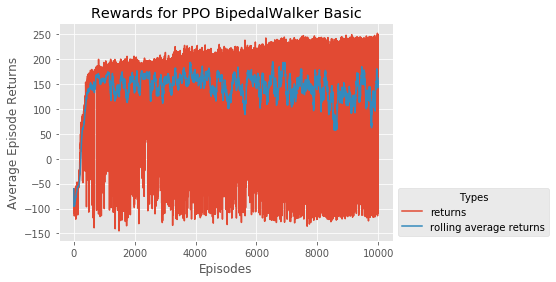

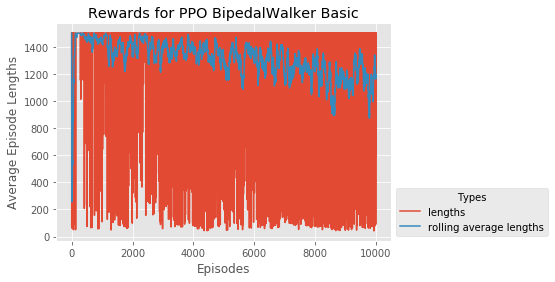

solved_episode_basic: 10000


In [43]:
rolling_avg_returns_basic = rolling_average(returns_basic, 50)
rolling_avg_lengths_basic = rolling_average(lengths_basic, 50)

plt.plot(range(len(returns_basic)), returns_basic, label='returns')
plt.plot(range(len(returns_basic)), rolling_avg_returns_basic, label='rolling average returns')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Returns')
plt.title('Rewards for PPO BipedalWalker Basic')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()

plt.plot(range(len(lengths_basic)), lengths_basic, label='lengths')
plt.plot(range(len(lengths_basic)), rolling_avg_lengths_basic, label='rolling average lengths')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Lengths')
plt.title('Rewards for PPO BipedalWalker Basic')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()

print(f'solved_episode_basic: {solved_episode_basic}')

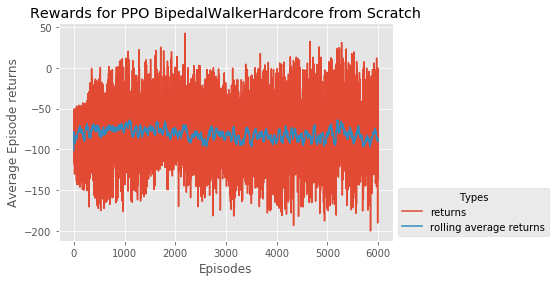

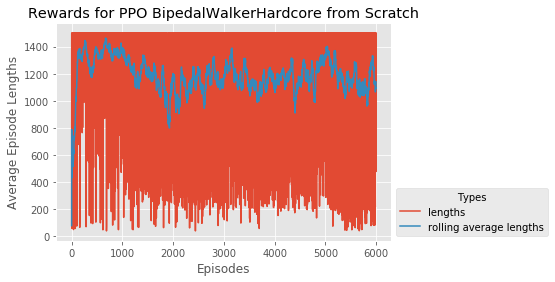

solved_episode_basic: 0


In [44]:
rolling_avg_returns_scratch = rolling_average(returns_scratch, 50)
rolling_avg_lengths_scratch = rolling_average(lengths_scratch, 50)

plt.plot(range(len(returns_scratch)), returns_scratch, label='returns')
plt.plot(range(len(returns_scratch)), rolling_avg_returns_scratch, label='rolling average returns')
plt.xlabel('Episodes')
plt.ylabel('Average Episode returns')
plt.title('Rewards for PPO BipedalWalkerHardcore from Scratch')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()

plt.plot(range(len(lengths_scratch)), lengths_scratch, label='lengths')
plt.plot(range(len(lengths_scratch)), rolling_avg_lengths_scratch, label='rolling average lengths')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Lengths')
plt.title('Rewards for PPO BipedalWalkerHardcore from Scratch')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()

print(f'solved_episode_basic: {solved_episode_scratch}')

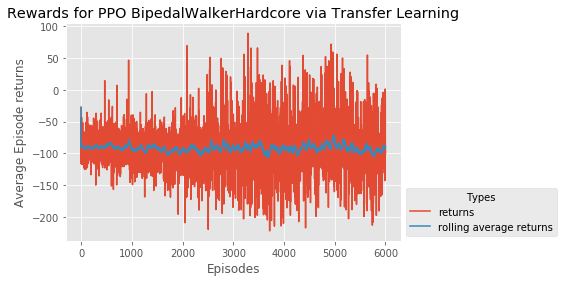

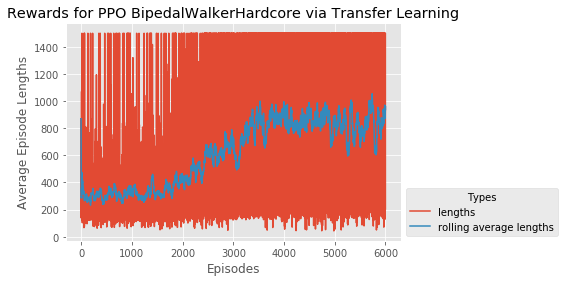

solved_episode_basic: 0


In [45]:
rolling_avg_returns_transfer = rolling_average(returns_transfer, 50)
rolling_avg_lengths_transfer = rolling_average(lengths_transfer, 50)

plt.plot(range(len(returns_transfer)), returns_transfer, label='returns')
plt.plot(range(len(returns_transfer)), rolling_avg_returns_transfer, label='rolling average returns')
plt.xlabel('Episodes')
plt.ylabel('Average Episode returns')
plt.title('Rewards for PPO BipedalWalkerHardcore via Transfer Learning')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()

plt.plot(range(len(lengths_transfer)), lengths_transfer, label='lengths')
plt.plot(range(len(lengths_transfer)), rolling_avg_lengths_transfer, label='rolling average lengths')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Lengths')
plt.title('Rewards for PPO BipedalWalkerHardcore via Transfer Learning')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()

print(f'solved_episode_basic: {solved_episode_transfer}')

### Plot scratch vs transfer

In [ ]:
plt.plot(range(len(rewards_transfer)), rolling_avg_rewards_scratch, label='rewards')
plt.plot(range(len(rewards_transfer)), rolling_avg_rewards_transfer, label='rolling average rewards')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Rewards')
plt.title('Rewards for PPO BipedalWalkerHardcore Scratch vs Transfer Learning')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()

plt.plot(range(len(lengths_transfer)), rolling_avg_lengths_scratch, label='lengths')
plt.plot(range(len(lengths_transfer)), rolling_avg_lengths_transfer, label='rolling average lengths')
plt.xlabel('Episodes')
plt.ylabel('Average Episode Lengths')
plt.title('Rewards for PPO BipedalWalkerHardcore Scratch vs Transfer Learning')
plt.legend(loc=3,bbox_to_anchor=(1,0), title='Types')
plt.show()